         date  close  log_close
0  2015-11-24  37.59       3.63
1  2015-11-25  37.59       3.63
2  2015-11-26  37.82       3.63
3  2015-11-27  37.68       3.63
4  2015-11-28  37.68       3.63
            close  log_close
date                        
2015-11-24  37.59       3.63
2015-11-25  37.59       3.63
2015-11-26  37.82       3.63
2015-11-27  37.68       3.63
2015-11-28  37.68       3.63


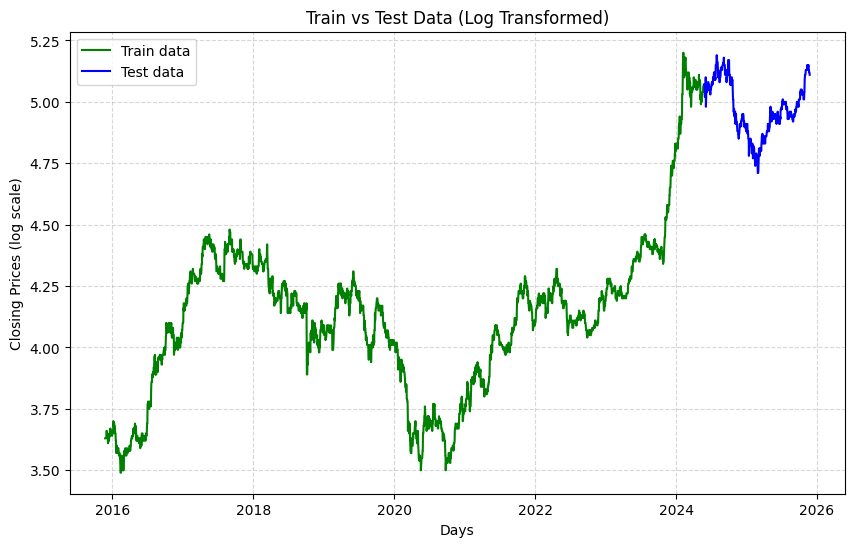

In [2]:
%run "../features/train-test_split.ipynb"

In [3]:
import warnings
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from statsmodels.tsa.arima.model import ARIMA

In [4]:
def fit_arima(df):
    warnings.simplefilter(action = 'ignore', category = Warning)
    print("Arima model for iocl")
    model = pm.auto_arima(df, test = 'adf', start_p=0, start_q=0, max_p=3, max_q=3, 
                          m=5, d=None, seasonal=True, start_P=0, D=None,start_Q=0, max_P=3, max_Q=3, trace = True,
                          error_action= 'ignore', suppress_warnings=True, stepwise=False, information_criterion= 'aic', n_jobs=-1, approximate = True)
    print(model.summary())
    model.plot_diagnostics(figsize= (15, 8))
    plt.show()

Arima model for iocl

Best model:  ARIMA(0,1,1)(0,0,0)[5] intercept
Total fit time: 49.191 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3105
Model:               SARIMAX(0, 1, 1)   Log Likelihood                8395.841
Date:                Tue, 25 Nov 2025   AIC                         -16785.683
Time:                        11:12:55   BIC                         -16767.562
Sample:                    11-24-2015   HQIC                        -16779.176
                         - 05-24-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      1.635      0.102   -9.22e-05       0.001
ma.L1         -0.0353      0.011

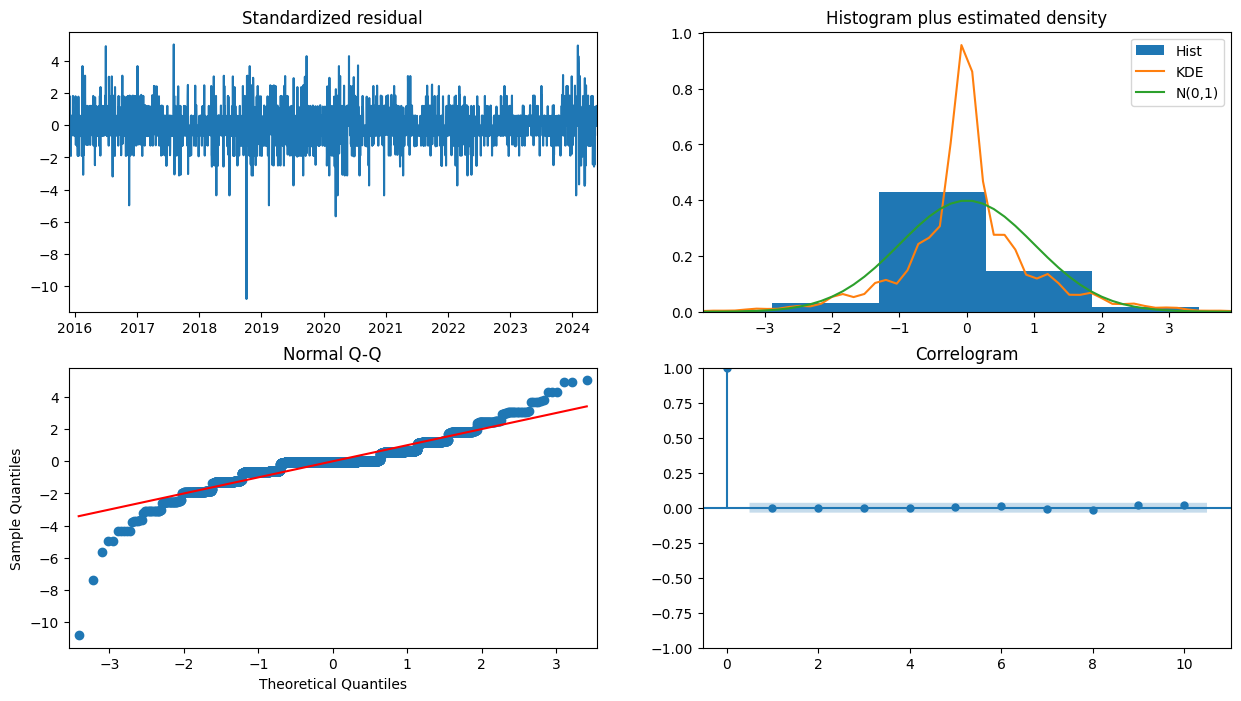

In [5]:
fit_arima(train_y)

In [6]:
# importing the model class 
# let's create an object of this model
model = SARIMAX(train_y, 
                order = (0, 1, 1), 
                seasonal_order = (0, 0, 0, 252),
                enforce_stationarity = False, 
                enforce_invertibility = False)
 
# apply the method fit
fitted = model.fit(maxiter = 500, method = 'nm')

Optimization terminated successfully.
         Current function value: -2.701470
         Iterations: 15
         Function evaluations: 30


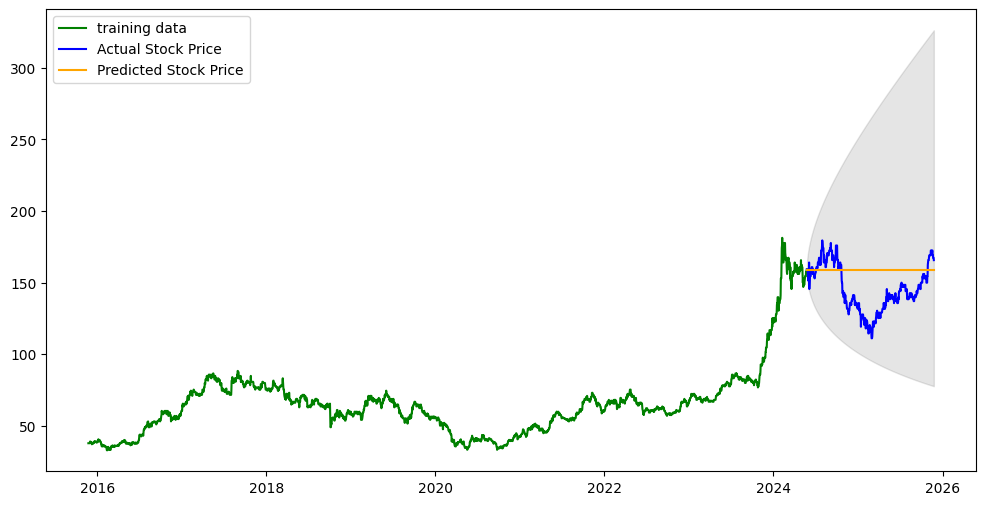

In [7]:
steps= len(test_y)
forecast_obj = fitted.get_forecast(steps=steps)
fc_log = forecast_obj.predicted_mean
conf_log = forecast_obj.conf_int(alpha=0.05)
fc = np.exp(fc_log)
conf = np.exp(conf_log)
# Make as pandas series
fc.index = test_y.index
conf.index = test_y.index

# Plot
plt.figure(figsize=(12,6), dpi=100)
plt.plot(np.exp(train_y),color = 'green', label='training data')
plt.plot(np.exp(test_y), color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.fill_between(conf.index, conf.iloc[:, 0], conf.iloc[:, 1], 
                 color='k', alpha=0.1)
plt.legend()
plt.show()

In [8]:
# report performance

mse = mean_squared_error(np.exp(test_y), fc)
mae = mean_absolute_error(np.exp(test_y), fc)
rmse = math.sqrt(mean_squared_error(np.exp(test_y), fc))
mape = np.mean(np.abs(np.exp(test_y) - fc)/np.abs(test_y))

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:',rmse)
print('MAPE:', mape)

MSE: 442.8127584551494
MAE: 17.77972528001417
RMSE: 21.04311665260518
MAPE: 3.620868374283317
